In [19]:
import numpy as np
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
%matplotlib inline
from scipy.cluster.hierarchy import dendrogram, linkage
import random
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
import numpy.linalg as la
from sklearn.metrics.pairwise import euclidean_distances
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [20]:
data = np.load("./data/mds-population.npz")
print (data['D']) # Distance matrix
print (data['population_list']) # List of populations

[[  0.  87.  12. ... 462. 559. 553.]
 [ 87.   0.  87. ... 210. 359. 285.]
 [ 12.  87.   0. ... 317. 401. 377.]
 ...
 [462. 210. 317. ...   0. 226. 173.]
 [559. 359. 401. ... 226.   0. 127.]
 [553. 285. 377. ... 173. 127.   0.]]
[b'Bantu' b'E. Afncan' b'Nilo-Saharan' b'W. African' b'San' b'Barter'
 b'Mbuti' b'Indian' b'Iranian' b'Near Eastern' b'Uralic' b'Ainu'
 b'Japanese' b'Korean' b'Mon Khmer' b'Thai' b'Dravidian' b'Mongol Tungus'
 b'Tibetan' b'Indonesian' b'Malaysian' b'Filipino' b'N. Turkic'
 b'S. Chinese' b'Basque' b'Lapp' b'Sardinian' b'Danish' b'English'
 b'Greek' b'Italian' b'C Amerind' b'Eskimo' b'Na-Dene' b'N. American'
 b'S. American' b'Chukchi' b'Melanesian' b'Micronesian' b'Polynesian'
 b'New Guinean' b'Australian']


# (a) Use MDS to coerce D into 2D vector representation

## i. What assumptions are being made? Under what circumstances could this fail? How could we measure how much information is being lost? 

If T was formed by computing pairwise Euclidean distances between the xi for i = 1,...,N, then T′ contains the corresponding inner products, i.e. T′ = XX⊤. (X is centered)

## ii. How many dimensions are necessary to capture most of the variation in the data?

In [28]:
ls = []
def mds(m):
    embedding = MDS(n_components=m)
    data_T = embedding.fit_transform(data['D'])
    D = euclidean_distances(data_T, data_T)
    loss = la.norm(data['D']-D)
    ls.append(loss)
for m in range (2, 21):
    mds(m)

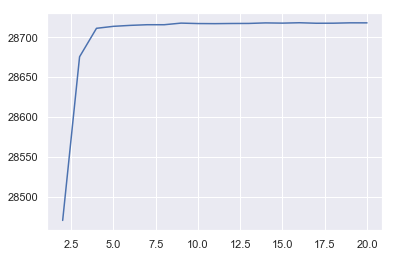

In [29]:
fig, ax = plt.subplots()
plt.plot(range(2,21),ls)
plt.show()

4 dimensions are necessary to caputure the most of variation of data.

## iii. Labelled 2D scatterplot

In [31]:
embedding = MDS(n_components=2)
data_T = embedding.fit_transform(data['D'])

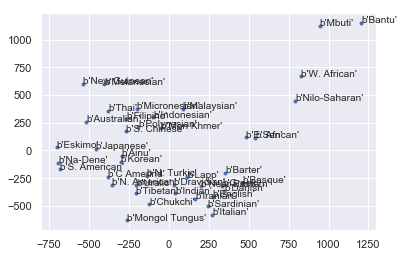

In [33]:
fig, ax = plt.subplots()
plt.plot(data_T[:,0],data_T[:,1],'.')
for i, txt in enumerate (data['population_list']):
    ax.annotate(txt, (data_T[:,0][i],data_T[:,1][i]))
plt.show()

# (b) k-means

3


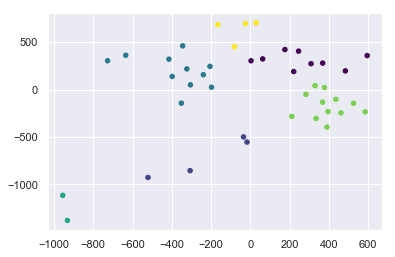

In [35]:
def plot_kmeans(kmeans, X, n_clusters=6, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    ax = ax or plt.gca()
    ax.scatter(X[:,0],X[:,1], c=labels, s=20, cmap='viridis', zorder=2)

kmeans = KMeans(n_clusters=6, random_state=0)
plot_kmeans(kmeans, data_T)
print(kmeans.n_iter_)
plt.show()

# (c) Hierachical clustering

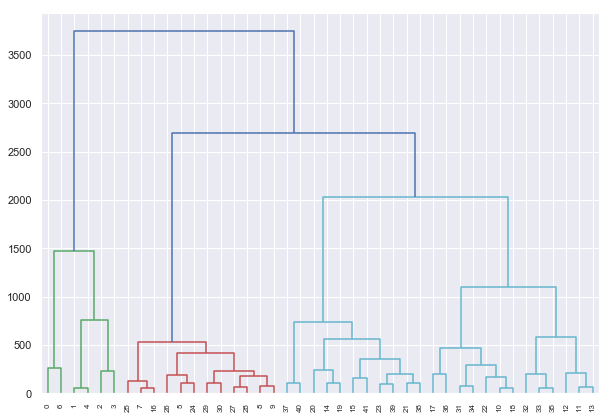

In [6]:
plt.figure(figsize=(10, 7))  
dend = shc.dendrogram(shc.linkage(data_T, method='ward'))  

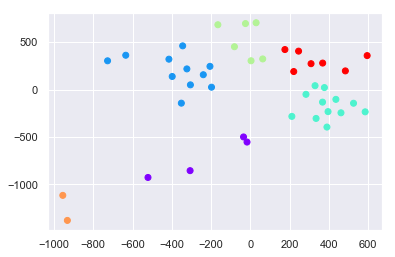

In [7]:
cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')  
cluster.fit_predict(data_T)  
plt.scatter(data_T[:,0], data_T[:,1], c=cluster.labels_, cmap='rainbow')

# (d) k-medoids

In [8]:
## Code from: https://github.com/salspaugh/machine_learning/blob/master/clustering/kmedoids.py
def cluster(distances, k):

    m = distances.shape[0] # number of points

    # Pick k random medoids.
    curr_medoids = np.array([-1]*k)
    while not len(np.unique(curr_medoids)) == k:
        curr_medoids = np.array([random.randint(0, m - 1) for _ in range(k)])
    old_medoids = np.array([-1]*k) # Doesn't matter what we initialize these to.
    new_medoids = np.array([-1]*k)
   
    # Until the medoids stop updating, do the following:
    while not ((old_medoids == curr_medoids).all()):
        # Assign each point to cluster with closest medoid.
        clusters = assign_points_to_clusters(curr_medoids, distances)

        # Update cluster medoids to be lowest cost point. 
        for curr_medoid in curr_medoids:
            cluster = np.where(clusters == curr_medoid)[0]
            new_medoids[curr_medoids == curr_medoid] = compute_new_medoid(cluster, distances)

        old_medoids[:] = curr_medoids[:]
        curr_medoids[:] = new_medoids[:]

    return clusters, curr_medoids

def assign_points_to_clusters(medoids, distances):
    distances_to_medoids = distances[:,medoids]
    clusters = medoids[np.argmin(distances_to_medoids, axis=1)]
    clusters[medoids] = medoids
    return clusters

def compute_new_medoid(cluster, distances):
    mask = np.ones(distances.shape)
    mask[np.ix_(cluster,cluster)] = 0.
    cluster_distances = np.ma.masked_array(data=distances, mask=mask, fill_value=10e9)
    costs = cluster_distances.sum(axis=1)
    return costs.argmin(axis=0, fill_value=10e9)

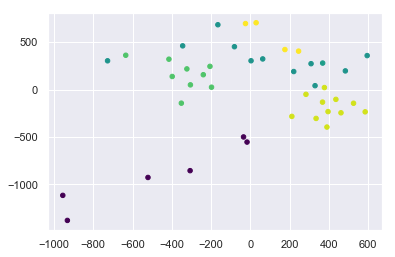

In [41]:
medoid_labels, medoids = cluster(data['D'],6)
fig, ax = plt.subplots()
ax.scatter(data_T[:,0],data_T[:,1], c=medoid_labels, s=20, cmap='viridis', zorder=2)
plt.show()

### Comparison between k-means and k-medoids